In [111]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [112]:
os.listdir()

['.ipynb_checkpoints',
 'helper_function.py',
 'Monkey Detection.ipynb',
 'monkeys',
 'tensorflow.ipynb',
 '__pycache__']

In [113]:
training_data_path = './monkeys/training'
test_data_path = './monkeys/validation'

In [114]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [115]:
train_dataset = torchvision.datasets.ImageFolder(root = training_data_path,transform = train_transforms)

In [116]:
train_loader_for_mean_std = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=False)

In [117]:
def get_mean_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images,_ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch,images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count

    return mean,std

In [118]:
mean,std = get_mean_std(train_loader_for_mean_std)

In [120]:
train_transform2 = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       # transforms.RandomHorizontalFlip(),
                                       # transforms.RandomRotation(10),
                                        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
                                      ])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
                                    ])

In [121]:
train_dataset = torchvision.datasets.ImageFolder(root=training_data_path,transform=train_transform2)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_path,transform=test_transform)

In [122]:
classes = train_dataset.classes
classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [126]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [127]:
def show_images(loader):
    batch = next(iter(loader))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels:',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([7, 3, 0, 4, 7, 6, 7, 4, 4, 5, 1, 3, 1, 5, 9, 7, 1, 3, 1, 4, 0, 6, 0, 3,
        4, 9, 3, 2, 6, 2, 3, 2])


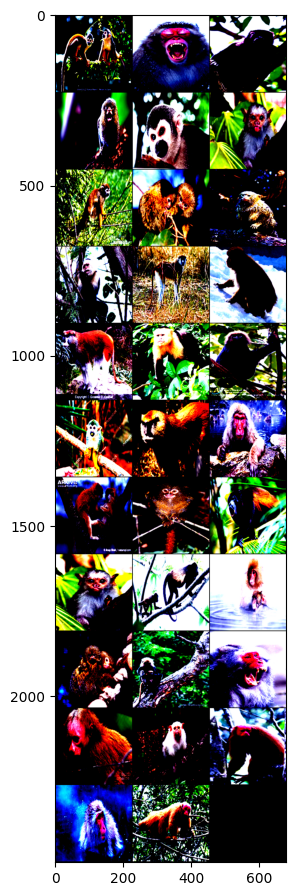

In [128]:
show_images(train_dataloader)

In [129]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [170]:
class MonkeyClassifierModelV0(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*28*28, # there is a trick to calculate this
                     out_features=hidden_units),   
        )
        self.classifier2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units,
                     out_features=output_shape),   
        )

    def forward(self,X):
        X = self.conv_block_1(X)
        # print(X.shape)
        X = self.conv_block_2(X)
        # print(X.shape)
        X = self.conv_block_3(X)
        # print(X.shape)
        X = self.classifier(X)
        # print(X.shape)
        X = self.classifier2(X)
        # print(X.shape)
        return X   

In [171]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [172]:
model = MonkeyClassifierModelV0(input_shape=3,hidden_units=20,output_shape=len(classes)).to(device)
model(image_batch.to(device))

tensor([[-0.1320, -0.0842,  0.2171, -0.0670,  0.2135, -0.2220,  0.0643,  0.1933,
         -0.2017,  0.2162],
        [-0.1279, -0.0791,  0.2191, -0.0707,  0.2159, -0.2184,  0.0621,  0.1926,
         -0.2053,  0.2192],
        [-0.1313, -0.0808,  0.2175, -0.0691,  0.2140, -0.2203,  0.0632,  0.1913,
         -0.2037,  0.2185],
        [-0.1300, -0.0812,  0.2196, -0.0680,  0.2180, -0.2173,  0.0608,  0.1902,
         -0.2027,  0.2145],
        [-0.1331, -0.0835,  0.2168, -0.0713,  0.2157, -0.2237,  0.0625,  0.1959,
         -0.2013,  0.2173],
        [-0.1290, -0.0857,  0.2193, -0.0718,  0.2176, -0.2176,  0.0620,  0.1943,
         -0.2033,  0.2137],
        [-0.1350, -0.0826,  0.2180, -0.0681,  0.2125, -0.2238,  0.0638,  0.1930,
         -0.2023,  0.2169],
        [-0.1346, -0.0831,  0.2187, -0.0684,  0.2172, -0.2193,  0.0626,  0.1940,
         -0.2026,  0.2140],
        [-0.1345, -0.0834,  0.2174, -0.0708,  0.2137, -0.2233,  0.0651,  0.1941,
         -0.2011,  0.2156],
        [-0.1329, -

In [173]:
import requests
from pathlib import Path

# Download helper function from Learn pytorch repo
if Path('helper_functions.py').is_file():
    print('helper_function.py already exists, skipping download')
else:
    print('Downloading helper_function.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_function.py','wb') as f:
        f.write(request.content)

In [174]:
from helper_function import accuracy_fn

In [175]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss ,train_acc = 0,0

    # put model on training mode
    model.train()

    ## add a loop to loop through the training batches
    for batch,(X,y) in enumerate(train_dataloader):
        # put data on target device
        X,y = X.to(device),y.to(device)

        #forward pass (outputs are the raw logits from model)
        y_pred = model(X)

        # calculate the loss and accuracy (per batch)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item() # accumulate the train loss
      
        # optimizer zero grad
        optimizer.zero_grad()

        #loss  backward (backpropagation)
        loss.backward()

        # optimizer step
        optimizer.step()

        # calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # divide total train loss and accuracy by length by length of train_dataloader
    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    # # print out what's happening
    # print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc}')
    return train_loss,train_acc

In [176]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a testing loop step on model going over data loader"""
    test_loss,test_acc = 0,0


    # put the model on eval mode
    model.eval()

    # turn on inference mode context manager
    with torch.inference_mode():
        for X,y in data_loader:
            # send the data on target data
            X,y = X.to(device),y.to(device)

            # forward pass
            test_pred_logits = model(X)

            # calculate the loss/acc
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            # calculate accuracy metric
            test_pred_labels = test_pred_logits.argmax(dim=1) 
            test_acc +=((test_pred_labels == y)).sum().item() / len(test_pred_labels)

    # adjust metrics to get avg
    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)

    return test_loss,test_acc

In [177]:
def train(model:torch.nn.Module,
         train_dataloader:torch.utils.data.DataLoader,
         test_dataloader:torch.utils.data.DataLoader,
         optimizer:torch.optim.Optimizer,
         loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          accuracy_fn = accuracy_fn,
         epochs: int = 5,
        device = device):

    # empty results dict
    results = {'train_loss':[],
   'train_acc':[],
   'test_loss':[],
    'test_acc':[],
    }

    # loop through traing and testing step for a number
    for epoch in tqdm(range(epochs)):
        train_loss ,train_acc = train_step(model=model,
                                          data_loader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                           accuracy_fn=accuracy_fn,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       data_loader=test_dataloader,
                                        accuracy_fn=accuracy_fn,
                                       loss_fn=loss_fn,
                                       device=device)
        # print what happening
        print(f'Epoch:{epoch} | Train loss: {train_loss:.4f} | Train acc:{train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

        # update results dict
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results


In [178]:
epochs = 5
model = MonkeyClassifierModelV0(input_shape=3,hidden_units=20,output_shape=len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr = 0.001)
model_results = train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                      accuracy_fn=accuracy_fn,
                     loss_fn=loss_fn,
                      epochs=epochs,
                      device=device
                     )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0 | Train loss: 2.1809 | Train acc:0.1927 | Test loss: 1.9764 | Test acc: 0.3507
Epoch:1 | Train loss: 1.7791 | Train acc:0.3900 | Test loss: 1.7914 | Test acc: 0.3924
Epoch:2 | Train loss: 1.3767 | Train acc:0.5221 | Test loss: 1.5472 | Test acc: 0.4757
Epoch:3 | Train loss: 1.1060 | Train acc:0.6404 | Test loss: 1.4132 | Test acc: 0.5104
Epoch:4 | Train loss: 0.6420 | Train acc:0.7968 | Test loss: 1.5784 | Test acc: 0.5174


In [181]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
epochs = 5
model = VGG16()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr = 0.001)
model_results = train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                      accuracy_fn=accuracy_fn,
                     loss_fn=loss_fn,
                      epochs=epochs,
                      device=device
                     )

  0%|          | 0/5 [00:00<?, ?it/s]